# Access Ticket Prediction

This notebook walks you through a **minimal viable pipeline** to:
1. Load historical access‑request tickets.
2. Engineer features that need *no extra systems*.
3. Train two models:
   * **WHO** will open a ticket in the next 7 days (classification / ranking).
   * **WHEN** that user will open the ticket (survival analysis).
4. Evaluate and inspect outputs.

---

## 0  Install / import dependencies

In [1]:
# Uncomment if running on a fresh environment
#!pip install pandas numpy scikit-learn xgboost lifelines matplotlib seaborn --quiet
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from xgboost import XGBClassifier
from lifelines import CoxPHFitter


## 1  Load data

In [2]:
# Point to your CSV (sample shipped with this repo / environment)
data_path = Path('sample_access_tickets.csv')
df_raw = pd.read_csv(data_path, parse_dates=['open_datetime'])
print(df_raw.shape)
df_raw.head()


(500, 7)


/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_21548/504164157.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw = pd.read_csv(data_path, parse_dates=['open_datetime'])


,requester_id,open_datetime,ticket_type,application_name,errors_401_last24h,errors_403_last24h,user_active
0,U004,2024-10-30 11:10:00,access_request,App_C,0,1,1
1,U037,2025-02-26 21:10:00,access_request,App_B,0,0,1
2,U003,2025-05-26 03:44:00,access_request,App_C,0,0,1
3,U011,2024-08-26 08:43:00,elevated_privilege,App_A,2,2,1
4,U042,2024-10-30 16:09:00,access_request,App_E,3,0,1


## 2  Basic EDA

In [3]:
print(df_raw['ticket_type'].value_counts(dropna=False))
print(df_raw['requester_id'].nunique(), 'unique users')
df_raw['open_datetime'].min(), df_raw['open_datetime'].max()


ticket_type
elevated_privilege    256
access_request        244
Name: count, dtype: int64
50 unique users


(Timestamp('2024-07-02 08:14:00'), Timestamp('2025-07-21 18:15:00'))

## 3  Feature engineering

In [4]:
### ==== 3  Feature engineering (robust version) ====
import pandas as pd, numpy as np

df = df_raw.copy()

# 1️⃣ Temporal atoms
df['dow']  = df['open_datetime'].dt.dayofweek      # 0 = Monday
df['hour'] = df['open_datetime'].dt.hour

# 2️⃣ Days since previous ticket per user
df = df.sort_values(['requester_id', 'open_datetime'])
df['prev_open'] = df.groupby('requester_id')['open_datetime'].shift(1)
df['days_since_prev'] = (
    (df['open_datetime'] - df['prev_open']).dt.total_seconds() / 86_400
)
median_gap = df['days_since_prev'].median()
df.loc[df['days_since_prev'].isna(), 'days_since_prev'] = median_gap   # no chained‑assign

# 3️⃣ Rolling ticket counts (past 7 & 30 days) — compatible with any Pandas ≥ 1.4
# --- Rolling ticket counts (past 7 & 30 days) ---
def rolling_count_per_row(group: pd.DataFrame, window_days: int) -> pd.Series:
    """
    For each row in <group>, return how many tickets that user opened
    in the trailing <window_days> (inclusive of the current row).
    Returns a Series aligned to `group.index`.
    """
    # Set datetime index so '7D' / '30D' offsets work
    g = group.set_index('open_datetime')
    # Dummy column equal to 1
    rolling_sum = (
        g.assign(dummy=1)['dummy']
        .rolling(f'{window_days}D')
        .sum()
        .astype('int64')             # safe: each element is scalar
        .reset_index(drop=True)      # keep row order intact
    )
    rolling_sum.index = group.index  # preserve original row index
    return rolling_sum

for win in (7, 30):
    df[f'cnt_{win}d'] = (
        df.groupby('requester_id', group_keys=False)
          .apply(lambda g, w=win: rolling_count_per_row(g, w))
          # .apply returns a Series already; no need for .astype(int)
    )

# 4️⃣ Final feature matrix
feature_cols = [
    'dow', 'hour', 'days_since_prev',
    'cnt_7d', 'cnt_30d',
    'errors_401_last24h', 'errors_403_last24h', 'user_active'
]

df[feature_cols].head()

/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_21548/1777835259.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g, w=win: rolling_count_per_row(g, w))
/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_21548/1777835259.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g, w=win: rolling_count_per_row(g, w))


,dow,hour,days_since_prev,cnt_7d,cnt_30d,errors_401_last24h,errors_403_last24h,user_active
44,5,11,23.468403,1,1,2,1,1
45,5,2,167.634722,1,1,0,0,1
476,5,17,35.615972,1,1,1,0,1
431,4,0,40.294444,1,1,1,0,1
409,1,14,11.588889,1,2,3,0,1


### 3.1  Labels for *WHO* model

In [5]:
H = 7  # prediction horizon in days
df['next_open'] = df.groupby('requester_id')['open_datetime'].shift(-1)
df['days_to_next'] = (df['next_open'] - df['open_datetime']).dt.total_seconds() / 86400
df['y_who'] = (df['days_to_next'] <= H).astype(int).fillna(0)
print(df['y_who'].value_counts(normalize=True))


y_who
0    0.852
1    0.148
Name: proportion, dtype: float64


## 4  Train / test split (time‑based)

In [6]:
cutoff_date = df['open_datetime'].quantile(0.8)
train = df[df['open_datetime'] <= cutoff_date]
test  = df[df['open_datetime']  > cutoff_date]
X_train, y_train = train[feature_cols], train['y_who']
X_test,  y_test  = test[feature_cols],  test['y_who']
print(train.shape, test.shape)


(400, 16) (100, 16)


## 5  Train *WHO* model (XGBoost)

In [7]:
model_who = XGBClassifier(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42
)
model_who.fit(X_train, y_train)
pred_probs = model_who.predict_proba(X_test)[:,1]
ap = average_precision_score(y_test, pred_probs)
roc = roc_auc_score(y_test, pred_probs)
print(f'Average Precision (PR AUC): {ap:.3f}\nROC AUC: {roc:.3f}')


Average Precision (PR AUC): 0.128
ROC AUC: 0.472


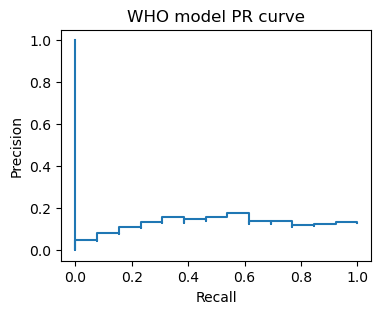

In [8]:
prec, recall, thr = precision_recall_curve(y_test, pred_probs)
plt.figure(figsize=(4,3))
plt.step(recall, prec, where='post')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('WHO model PR curve')
plt.show()


### 5.1  Top‑10 user predictions for next horizon

In [9]:
# Take most recent record per user in test set
latest_test = test.sort_values('open_datetime').groupby('requester_id').tail(1)
scores = model_who.predict_proba(latest_test[feature_cols])[:,1]
top10 = (
    latest_test.assign(score=scores)
    .sort_values('score', ascending=False)
    .head(10)[['requester_id', 'open_datetime', 'score']]
)
top10


,requester_id,open_datetime,score
454,U032,2025-07-12 13:06:00,0.725505
177,U044,2025-07-07 13:27:00,0.569524
165,U010,2025-07-14 04:50:00,0.496402
82,U022,2025-07-11 15:40:00,0.429868
202,U030,2025-07-07 06:25:00,0.393878
210,U045,2025-05-30 05:34:00,0.377355
295,U023,2025-07-10 14:31:00,0.364329
90,U011,2025-07-06 07:14:00,0.295986
245,U008,2025-07-17 10:50:00,0.241324
189,U029,2025-07-13 15:30:00,0.208529


## 6  Train *WHEN* model (Cox Proportional Hazards)

In [10]:
# Prepare survival dataset per user
surv = (
    df.groupby('requester_id')
      .apply(lambda g: pd.Series({
          'duration': (g['open_datetime'].max() - g['open_datetime'].min()).days + 0.1,
          'event': 1  # at least one ticket observed
      }))
      .reset_index()
)

# Aggregate user‑level features (mean)
user_feats = df.groupby('requester_id')[feature_cols].mean().reset_index()
surv_df = pd.merge(surv, user_feats, on='requester_id')

# Train/test split
train_u, test_u = train_test_split(surv_df, test_size=0.2, random_state=42)

cph = CoxPHFitter()
cph.fit(train_u.drop(columns=['requester_id']), duration_col='duration', event_col='event')
cph.print_summary()

# Concordance on test set
from lifelines.utils import concordance_index
pred_surv = -cph.predict_partial_hazard(test_u)
cindex = concordance_index(test_u['duration'], pred_surv, test_u['event'])
print(f'C‑index on held‑out users: {cindex:.3f}')


/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_21548/3197340575.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


<lifelines.CoxPHFitter: fitted with 40 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 40
number of events observed = 40
   partial log-likelihood = -107.33
         time fit was run = 2025-07-23 04:50:54 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
dow                -0.05      0.95      0.30           -0.63            0.53                0.53                1.70
hour                0.07      1.08      0.10           -0.12            0.27                0.88                1.31
days_since_prev    -0.05      0.95      0.02           -0.10           -0.00                0.91                1.00
cnt_7d              0.85      2.35      1.68           -2.44            4.14                0.09               62.85
cnt_30d            -1.57      0.21      0.97           -3.47            0.33                0.03                1.39
errors_401_last24h -0.13      0.88      0.63           -1.36            1.10                0.26                3.01
errors_403_last24h -0.68      0.51      0.82           -2.29            0.92                0.10                2.51
user_active         0.52      1.69      2.37           -4.13            5.18                0.02              177.58

                    cmp to     z    p  -log2(p)
covariate                                      
dow                   0.00 -0.17 0.86      0.21
hour                  0.00  0.73 0.47      1.10
days_since_prev       0.00 -2.08 0.04      4.74
cnt_7d                0.00  0.51 0.61      0.71
cnt_30d               0.00 -1.62 0.10      3.26
errors_401_last24h    0.00 -0.20 0.84      0.25
errors_403_last24h    0.00 -0.83 0.40      1.31
user_active           0.00  0.22 0.83      0.28
---
Concordance = 0.63
Partial AIC = 230.65
log-likelihood ratio test = 5.99 on 8 df
-log2(p) of ll-ratio test = 0.62

C‑index on held‑out users: 0.432


In [11]:
## 6 a. Evaluate the WHO model on the test period

In [12]:
### ==== 6 a  WHO model – full test‑set metrics ====
# ---- Top‑k recall (@10) ----
# Make sure model_who, X_test exist (Step 5 & Step 4 must have run)
probs_test = model_who.predict_proba(X_test)[:, 1]

k = 10

# 1️⃣  Add the probabilities to every row of the test set
test_with_probs = test.copy()
test_with_probs['prob'] = probs_test          # lengths match (100 rows)

# 2️⃣  Identify *next* ticket rows (positive labels)
next_tickets = test_with_probs[test_with_probs['y_who'] == 1]

# 3️⃣  For each user, keep the last record BEFORE the horizon
latest_rows = (
    test_with_probs
        .sort_values('open_datetime')
        .groupby('requester_id')
        .tail(1)            # one row per user
)

# 4️⃣  Pick Top‑k users
topk_users = (
    latest_rows.sort_values('prob', ascending=False)
               .head(k)['requester_id']
               .tolist()
)

# 5️⃣  Compute recall
recall_at_k = next_tickets['requester_id'].isin(topk_users).mean()
print(f"WHO  – Top‑{k} recall (7‑day horizon): {recall_at_k:.2%}")


WHO  – Top‑10 recall (7‑day horizon): 23.08%


In [13]:
### ==== 6 b  WHEN model – test MAE & C‑index ====
from lifelines.utils import concordance_index

# Median predicted days to event
median_pred_days = cph.predict_median(test_u).rename('pred_days')
actual_days      = test_u['duration']

mae = (median_pred_days - actual_days).abs().mean()
print(f"WHEN – MAE on users with next ticket: {mae:.1f} days")

cindex = concordance_index(actual_days, -cph.predict_partial_hazard(test_u), test_u['event'])
print(f"WHEN – C‑index: {cindex:.3f}")

WHEN – MAE on users with next ticket: 46.0 days
WHEN – C‑index: 0.432


In [14]:
### ==== 7  Predict who & when *today* ====
### ==== 7  Predict who & when *today*  (PATCHED, self‑contained) ====

# ---------- CONFIG ----------
H_PRED = 7      # horizon in days
TOP_N  = 10     # how many users you want in the shortlist
# -----------------------------

# 1️⃣  Find “now” (latest timestamp in your data)
today_dt = df['open_datetime'].max()

# 2️⃣  One latest row per user up to 'today'
latest_rows_now = (
    df[df['open_datetime'] <= today_dt]
      .sort_values('open_datetime')
      .groupby('requester_id', as_index=False)
      .tail(1)                          # returns DataFrame, preserves index
      .reset_index(drop=True)
)

# 3️⃣  WHO probability for each user
latest_rows_now['prob_who'] = (
    model_who.predict_proba(latest_rows_now[feature_cols])[:, 1]
)

# 4️⃣  Pick the TOP_N most‑likely users
candidates = (
    latest_rows_now.sort_values('prob_who', ascending=False)
                   .head(TOP_N)
                   .copy()
)

# 5️⃣  Build user‑level feature vectors for the WHEN model
user_feats_now = (
    candidates[['requester_id'] + feature_cols]     # keep only needed cols
        .groupby('requester_id', as_index=False)
        .mean()
)

# 6️⃣  Predict expected days → convert to hours
model_feats = cph.params_.index  # features Cox model was trained with
if hasattr(cph, "predict_expectation"):             # lifelines ≥ 0.26
    expected_days = cph.predict_expectation(user_feats_now[model_feats])
else:                                               # older versions
    expected_days = cph.predict_expected(user_feats_now[model_feats])

user_feats_now['pred_hours_to_ticket'] = expected_days * 24  # days → hours

# 7️⃣  Merge WHO + WHEN signals
final_pred = (
    candidates[['requester_id', 'prob_who']]
        .merge(user_feats_now[['requester_id', 'pred_hours_to_ticket']],
               on='requester_id')
        .sort_values('prob_who', ascending=False)
        .reset_index(drop=True)
)

# 8️⃣  Display
final_pred


,requester_id,prob_who,pred_hours_to_ticket
0,U032,0.725505,2063.318389
1,U044,0.569524,3722.473706
2,U010,0.496402,1932.740989
3,U022,0.429868,5067.636583
4,U030,0.393878,5017.239156
5,U045,0.377355,2707.214781
6,U023,0.364329,4866.613861
7,U011,0.295986,2457.501324
8,U008,0.241324,2626.716708
9,U029,0.208529,3614.945647
